# Example Brick Model for process
Example brick model will be 2 AHUs, 60 terminal units.
Half are for perimeter zones vavs with reheat, half are for core zones and are cooling only 

10 core zone terminal units are for mechanical rooms, networking closets, and electrical rooms that must be served 24/7

In [1]:
from rdflib import Namespace, URIRef, RDFS, Graph, Literal
from buildingmotif import BuildingMOTIF
from buildingmotif.dataclasses import Model, Library
from buildingmotif.namespaces import BMOTIF, BRICK, A, RDF, S223
from buildingmotif.model_builder import TemplateBuilderContext
from time import time


In [2]:
BLDG = Namespace("urn:example#")
bm = BuildingMOTIF("sqlite://", "topquadrant")
bldg = Model.create("urn:example#")
bldg.graph.bind('',BLDG)
bldg.graph.bind('s223',S223)

In [3]:
brick_tmpl = Library.load(directory='s223-templates')

In [4]:

ctx = TemplateBuilderContext(BLDG)
ctx.add_templates_from_library(brick_tmpl)

In [5]:
def get_wrapper_dict(ctx):
    wrapper_dict = {}
    for wrapper in ctx.wrappers:
        if wrapper.template.name not in wrapper_dict.keys():
            wrapper_dict[wrapper.template.name] = [wrapper]
        else:
            wrapper_dict[wrapper.template.name].append(wrapper)
    return wrapper_dict

In [6]:
wrapper_dict = get_wrapper_dict(ctx)
template_types = wrapper_dict.keys()
print(template_types)

dict_keys([])


In [7]:
ahu = brick_tmpl.get_template_by_name('multiple-zone-ahu')

In [8]:
def assemble_ahu(bindings):
    components = ['sa_fan', 'ra_damper', 'clg_coil', 'htg_coil']
    for i in range(1, len(components)): 
        ctx['feeds'](name = bindings[components[i-1]], target = bindings[components[i]])
    # ctx['in-maps-to'](name = bindings['name'], target = bindings[components[0]])
    ctx['out-maps-to'](name = bindings['name'], target = bindings[components[-1]])

In [9]:
g = Graph()
g.bind('',BLDG)
g.bind('s223',S223)

bldg_config = {'ahus': 4, 'cv': 15, 'hv': 15}
bldg_ctx_dict = {}
for i in range(bldg_config['ahus']):
    template_name = 'multiple-zone-ahu'
    ahu_name = f'ahu_{i}'
    ahu = ctx[template_name](name=ahu_name)
    ahu.bindings = {k: BLDG[f"{template_name}_{k}_{i}"] for k in ahu.parameters}
    assemble_ahu(ahu.bindings)
    # display(ahu.bindings)
    # also adding to condensed representation 
    for k,v in ahu.bindings.items():
        # g.add((BLDG[f"{template_name}-{k.replace('name-','')}"], RDF[f"_{i+1}"], v))
        g.add((BLDG[f"{template_name}-{k.replace('name-','')}"], RDFS[f"member"], v))
    for cv in range(bldg_config['cv']):
        template_name = 'vav-cooling-only'
        cv_name = f'cvav_{i}_{cv}'
        cvav = ctx[template_name](name=cv_name)
        cvav.bindings = {k: BLDG[f"{template_name}_{k}_{i}_{cv}"] for k in cvav.parameters}
        ctx['feeds'](name = ahu['name'], outlet_cp = ahu_name + 'out', connection = ahu_name + 'con', inlet_cp = cvav.bindings['air-inlet-connectionpoint'], target = cvav['name'])
        for k,v in cvav.bindings.items():
            # g.add((BLDG[f"{template_name}-{k.replace('name-','')}"], RDF[f"_{cv+1}"], v))
            g.add((BLDG[f"{template_name}-{k.replace('name-','')}"], RDFS[f"member"], v))
        # print(cvav.bindings)
    for hv in range(bldg_config['hv']):
        template_name = 'vav-with-reheat'
        hv_name = f'hvav_{i}_{hv}'
        hvav = ctx[template_name](name=hv_name)
        hvav.bindings = {k: BLDG[f"{template_name}_{k}_{i}_{hv}"] for k in hvav.parameters}
        ctx['feeds'](name = ahu['name'], outlet_cp = ahu_name + 'out', connection = ahu_name + 'con', inlet_cp = hvav.bindings['name-air-inlet-connectionpoint'], target = hvav['name'])
        for k,v in hvav.bindings.items():
            # g.add((BLDG[f"{template_name}-{k.replace('name-','')}"], RDF[f"_{hv+1}"], v))
            g.add((BLDG[f"{template_name}-{k.replace('name-','')}"], RDFS[f"member"], v))

wrapper_dict = get_wrapper_dict(ctx)
template_types = wrapper_dict.keys()

skip_templates = ['feeds']
for tp in template_types:
    if tp in skip_templates:
        continue
    for wrapper in wrapper_dict[tp]:
        params = wrapper.parameters
        eval_dict = {}
        for param in params:
            # if param not in TEMPLATE_PARAMS_COMPILED[tp].keys():
            #     print(param)
            # g.add((BLDG[f"{tp}-{param.replace('name-','')}"], A, BRICK[TEMPLATE_PARAMS_COMPILED[tp][param]]))
            name = f"{tp}-{param.replace('name-','')}"
            g.add((BLDG[name], A, RDF.Seq))
            eval_dict[param] = BLDG[name]
        template_graph = wrapper.template.evaluate(eval_dict)
        if not isinstance(template_graph, Graph):
            print('not a graph, cant add')
        g = g + template_graph
    # adding feeds manually 
    connection_template = brick_tmpl.get_template_by_name('feeds')
    g = g+ connection_template.inline_dependencies().evaluate({
        'inlet_cp': BLDG['vav-cooling-only-name']+'_in', 
        'connection': BLDG['multiple-zone-ahu-name']+'_cn', 
        'name': BLDG['multiple-zone-ahu-name'],
        'target': BLDG['vav-cooling-only-name'],
        'outlet_cp': BLDG['multiple-zone-ahu-name']+'_out',
    })
    g = g+ connection_template.inline_dependencies().evaluate({
        'inlet_cp': BLDG['vav-with-reheat-name']+'_in', 
        'connection': BLDG['multiple-zone-ahu-name']+'_cn', 
        'name': BLDG['multiple-zone-ahu-name'],
        'target': BLDG['vav-with-reheat-name'],
        'outlet_cp': BLDG['multiple-zone-ahu-name']+'_out',
    })


In [10]:
# add inverse cnx
def add_inverse_cnx(g):
    query = """ CONSTRUCT {
        ?s s223:cnx ?o
    }
    WHERE {
        ?o s223:cnx ?s
    }
    """
    g += g.query(query).graph

In [11]:
add_inverse_cnx(g)
g.serialize('s223-example-groups.ttl', format = 'ttl')

<Graph identifier=N00a0e4c15e01438085bef9c0717aafa9 (<class 'rdflib.graph.Graph'>)>

In [12]:
g_no_data = g.query("""
            CONSTRUCT {
                   ?s ?p ?o .
            }
            WHERE {
            ?s ?p ?o .
            FILTER (?p != rdfs:member) .
            }
                   """).graph

def get_label(s):
    name= str(s).rsplit('-')[-1] if str(s).rsplit('-')[-1] != 'name' else str(s).rsplit('-')[-2]
    return Literal(name)
# rtrying no labels
# for s,p,o in g_no_data.triples((None,None,None)):    
#     if p == A:
#         continue               
#     if p == BRICK.hasPoint:
#         g_no_data.add((o, A, BRICK.Point))
#     g_no_data.add((s, RDFS.label, get_label(s)))
#     g_no_data.add((o, RDFS.label, get_label(o)))

g_no_data.bind('bldg',BLDG)

In [13]:
QK = Namespace("http://qudt.org/vocab/quantitykind/")
g_no_data.bind('quantitykind',QK)
g_no_data.serialize("s223-example-groups-no-data.ttl", format = 'ttl')

<Graph identifier=N8537ec705a5a4575bda4fd91ef0af5a0 (<class 'rdflib.graph.Graph'>)>

In [14]:
bldg.add_graph(ctx.compile())
add_inverse_cnx(bldg.graph)
bldg.graph.serialize('s223-example.ttl', format = 'ttl')

/Users/lazlopaul/Desktop/223p/experiments/graph-pattern-id/.venv/lib/python3.10/site-packages/buildingmotif/dataclasses/template.py:420: UserWarning: Parameters "connection, inlet_cp, outlet_cp" were not provided during evaluation
  warnings.warn(
/Users/lazlopaul/Desktop/223p/experiments/graph-pattern-id/.venv/lib/python3.10/site-packages/buildingmotif/dataclasses/template.py:420: UserWarning: Parameters "outlet_cp, target_cp" were not provided during evaluation
  warnings.warn(


<Graph identifier=1686e57d-ccb0-4ef4-b372-8d8a9ee5110f (<class 'rdflib.graph.Graph'>)>

# Querying

In [ ]:
# example query. What is the discharge air temperature of cooling only VAVs
import sys
import os
# current_dir = os.path.dirname(__file__)
# utils_path = os.path.abspath(os.path.join(current_dir, '..', 'utils'))
sys.path.insert(0, '../utils')
from utils import query_to_df, get_prefixes



In [ ]:
bldg_g = Graph(store = 'Oxigraph')
for s,p,o in bldg.graph.triples((None,None,None)):
    bldg_g.add((s,p,o))
bldg_g_normal = Graph()
for s,p,o in bldg.graph.triples((None,None,None)):
    bldg_g_normal.add((s,p,o))

In [ ]:
st = time()
bldg_query = get_prefixes(bldg.graph)
bldg_query += """
PREFIX quantitykind: <http://qudt.org/vocab/quantitykind/>
SELECT ?dat ?vav ?ahu
WHERE {
    ?dat a s223:QuantifiableObservableProperty ;
        s223:hasQuantityKind quantitykind:Temperature .
    ?vav a s223:SingleDuctTerminal ;
        s223:contains ?dmp .
    ?dmp a s223:Damper . 
    ?vav s223:cnx ?outlet_cp . 
    ?outlet_cp a s223:OutletConnectionPoint ;
        s223:hasProperty ?dat .
    ?ahu a s223:AirHandlingUnit ;
        s223:cnx* ?vav .
    FILTER NOT EXISTS {
        ?vav s223:contains ?rc .
        ?rc a s223:Coil .
    }
}
"""
display(query_to_df(bldg_query, bldg_g))
et = time()
elapsed_time = et - st
print(elapsed_time)

,dat,vav,ahu
0,urn:example#vav-cooling-only_dat_2_13,urn:example#vav-cooling-only_name_2_13,urn:example#multiple-zone-ahu_name_2
1,urn:example#vav-cooling-only_dat_2_0,urn:example#vav-cooling-only_name_2_0,urn:example#multiple-zone-ahu_name_2
2,urn:example#vav-cooling-only_dat_1_14,urn:example#vav-cooling-only_name_1_14,urn:example#multiple-zone-ahu_name_1
3,urn:example#vav-cooling-only_dat_2_8,urn:example#vav-cooling-only_name_2_8,urn:example#multiple-zone-ahu_name_2
4,urn:example#vav-cooling-only_dat_3_3,urn:example#vav-cooling-only_name_3_3,urn:example#multiple-zone-ahu_name_3
5,urn:example#vav-cooling-only_dat_3_5,urn:example#vav-cooling-only_name_3_5,urn:example#multiple-zone-ahu_name_3
6,urn:example#vav-cooling-only_dat_3_7,urn:example#vav-cooling-only_name_3_7,urn:example#multiple-zone-ahu_name_3
7,urn:example#vav-cooling-only_dat_2_3,urn:example#vav-cooling-only_name_2_3,urn:example#multiple-zone-ahu_name_2
8,urn:example#vav-cooling-only_dat_1_0,urn:example#vav-cooling-only_name_1_0,urn:example#multiple-zone-ahu_name_1
9,urn:example#vav-cooling-only_dat_0_2,urn:example#vav-cooling-only_name_0_2,urn:example#multiple-zone-ahu_name_0


0.014512777328491211


In [ ]:
st = time()
bldg_query = get_prefixes(bldg.graph)
bldg_query += """
SELECT Distinct *
WHERE {
    ?vav a s223:SingleDuctTerminal .
    ?ahu a s223:AirHandlingUnit .
    ?ahu s223:cnx* ?vav .
}
"""
display(query_to_df(bldg_query, bldg_g_normal))
et = time()
elapsed_time = et - st
print(elapsed_time)

,ahu,vav
0,urn:example#multiple-zone-ahu_name_3,urn:example#vav-with-reheat_name_3_1
1,urn:example#multiple-zone-ahu_name_3,urn:example#vav-with-reheat_name_3_2
2,urn:example#multiple-zone-ahu_name_3,urn:example#vav-with-reheat_name_3_7
3,urn:example#multiple-zone-ahu_name_3,urn:example#vav-cooling-only_name_3_2
4,urn:example#multiple-zone-ahu_name_3,urn:example#vav-with-reheat_name_3_11
...,...,...
115,urn:example#multiple-zone-ahu_name_1,urn:example#vav-cooling-only_name_1_0
116,urn:example#multiple-zone-ahu_name_1,urn:example#vav-cooling-only_name_1_3
117,urn:example#multiple-zone-ahu_name_1,urn:example#vav-with-reheat_name_1_13
118,urn:example#multiple-zone-ahu_name_1,urn:example#vav-cooling-only_name_1_11


0.28844499588012695


In [ ]:
st = time()
bldg_query = get_prefixes(bldg.graph)
bldg_query += """
SELECT ?ahu ?vav
WHERE {
    ?vavC a s223:SingleDuctTerminal, rdf:Seq ;
        rdfs:member ?vav .
    ?ahuC a s223:AirHandlingUnit, rdf:Seq ;
        rdfs:member ?ahu .
    ?ahu s223:cnx* ?vav .
}
"""
display(query_to_df(bldg_query, bldg_g_normal + g))
et = time()
elapsed_time = et - st
print(elapsed_time)

,ahu,vav
0,urn:example#multiple-zone-ahu_name_0,urn:example#vav-cooling-only_name_0_7
1,urn:example#multiple-zone-ahu_name_0,urn:example#vav-cooling-only_name_0_11
2,urn:example#multiple-zone-ahu_name_0,urn:example#vav-cooling-only_name_0_3
3,urn:example#multiple-zone-ahu_name_0,urn:example#vav-cooling-only_name_0_6
4,urn:example#multiple-zone-ahu_name_0,urn:example#vav-cooling-only_name_0_12
...,...,...
115,urn:example#multiple-zone-ahu_name_2,urn:example#vav-with-reheat_name_2_4
116,urn:example#multiple-zone-ahu_name_2,urn:example#vav-with-reheat_name_2_0
117,urn:example#multiple-zone-ahu_name_2,urn:example#vav-with-reheat_name_2_9
118,urn:example#multiple-zone-ahu_name_2,urn:example#vav-with-reheat_name_2_5


0.3323230743408203


In [ ]:
st = time()
bldg_query = get_prefixes(bldg.graph)
bldg_query += """
SELECT ?dat ?vav ?ahu
WHERE {
    ?dat a s223:QuantifiableObservableProperty .
    ?vavC a s223:SingleDuctTerminal ;
        rdfs:member ?vav ;
        s223:contains ?dmp .
    ?dmp a s223:Damper . 
    ?vav s223:cnx ?outlet_cp . 
    ?outlet_cp a s223:OutletConnectionPoint ;
        s223:hasProperty ?dat .
    ?ahuC a s223:AirHandlingUnit, rdf:Seq ;
        rdfs:member ?ahu .
    ?ahu s223:cnx* ?vav .
    FILTER NOT EXISTS {
        ?vavC s223:contains ?rc .
        ?rc a s223:Coil .
    }
}
"""
display(query_to_df(bldg_query, bldg_g_normal + g))
et = time()
elapsed_time = et - st
print(elapsed_time)

KeyboardInterrupt: 

In [ ]:
# to use the alternative representation, just need to query for members of hte container
# things that don't ask for topology - really fast and easy
group_query = """
SELECT ?dat 
WHERE {
    ?datC a brick:Discharge_Air_Temperature_Sensor .
    ?vav a brick:VAV .
    ?vav brick:hasPoint ?datC .
    FILTER NOT EXISTS {
        ?vav brick:hasPart ?rc .
        ?rc a brick:Heating_Coil .
    }
    ?datC rdfs:member ?dat
}
"""
st = time()
query_to_df(group_query, g)
et = time()
elapsed_time = et - st
print(elapsed_time)

0.01220703125


In [ ]:
# things that do ask for topology are still faster when using the overlayer than without 
group_bldg_query_wrong = """
SELECT ?dat ?vav ?ahu
WHERE {
    ?dat a brick:Discharge_Air_Temperature_Sensor .
    ?vav a brick:VAV .
    ?vav brick:hasPoint ?dat .
    ?ahu brick:feeds ?vav
    FILTER NOT EXISTS {
        ?vav brick:hasPart ?rc .
        ?rc a brick:Heating_Coil .
    }
}
"""

query_to_df(group_bldg_query_wrong, bldg.graph)

,dat,vav,ahu


In [ ]:
# Routing queries through alternative representation where topology only used to filter is still faster
group_bldg_query = """
SELECT ?dat ?vav ?ahu
WHERE {
    ?vavC a brick:VAV .
    ?vavC rdfs:member ?vav .
    ?ahu brick:feeds ?vav .
    ?vav brick:hasPoint ?dat .
    ?dat a brick:Discharge_Air_Temperature_Sensor .
    FILTER NOT EXISTS {
        ?vavC brick:hasPart ?rc .
        ?rc a brick:Heating_Coil .
    }
}
"""
query_to_df(group_bldg_query, bldg.graph + g)

,dat,vav,ahu
0,urn:example#vav-cooling-only_dat_1_7,urn:example#vav-cooling-only_name_1_7,urn:example#multiple-zone-ahu_name_1
1,urn:example#vav-cooling-only_dat_1_11,urn:example#vav-cooling-only_name_1_11,urn:example#multiple-zone-ahu_name_1
2,urn:example#vav-cooling-only_dat_3_13,urn:example#vav-cooling-only_name_3_13,urn:example#multiple-zone-ahu_name_3
3,urn:example#vav-cooling-only_dat_1_0,urn:example#vav-cooling-only_name_1_0,urn:example#multiple-zone-ahu_name_1
4,urn:example#vav-cooling-only_dat_1_1,urn:example#vav-cooling-only_name_1_1,urn:example#multiple-zone-ahu_name_1
5,urn:example#vav-cooling-only_dat_2_14,urn:example#vav-cooling-only_name_2_14,urn:example#multiple-zone-ahu_name_2
6,urn:example#vav-cooling-only_dat_3_8,urn:example#vav-cooling-only_name_3_8,urn:example#multiple-zone-ahu_name_3
7,urn:example#vav-cooling-only_dat_0_14,urn:example#vav-cooling-only_name_0_14,urn:example#multiple-zone-ahu_name_0
8,urn:example#vav-cooling-only_dat_2_3,urn:example#vav-cooling-only_name_2_3,urn:example#multiple-zone-ahu_name_2
9,urn:example#vav-cooling-only_dat_3_0,urn:example#vav-cooling-only_name_3_0,urn:example#multiple-zone-ahu_name_3


In [ ]:
print("Triple Counts")
print(f" - Full Graph: {len(bldg.graph)}")
print(f" - Short Graph with Links to Full Graph: {len(g)}")
print(f" - Short Graph without Links to Full Graph: {len(g_no_data)}")
print(f"Reduction for Human Readability: {(1 - len(g_no_data)/len(bldg.graph)) * 100}%")


Triple Counts
 - Full Graph: 3429
 - Short Graph with Links to Full Graph: 1245
 - Short Graph without Links to Full Graph: 123
Reduction for Human Readability: 96.41294838145232%


### asking Gemini 2.5 Flash to write a query given the file 
<model>
pasted brick-example-groups-no-data.ttl
</model>
Please author a SPARQL query for a brick semantic model that will retreive the discharge air temperature of each vav, and the ahu that feeds each vav.


provided with the model and without the model. 


In [ ]:
query = """PREFIX bldg: <urn:example#>
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?vav ?vavLabel ?datSensor ?datLabel ?feedingAHU ?ahuLabel
WHERE {
  ?vav a brick:VAV .
  ?vav rdfs:label ?vavLabel .

  ?vav brick:hasPoint ?datSensor .
  ?datSensor a brick:Discharge_Air_Temperature_Sensor .
  ?datSensor rdfs:label ?datLabel .

  ?feedingAHU a brick:AHU .
  ?feedingAHU brick:feeds ?vav .
  ?feedingAHU rdfs:label ?ahuLabel .
}
"""
query_to_df(query, bldg.graph)

,vav,vavLabel,datSensor,datLabel,feedingAHU,ahuLabel
0,urn:example#vav-cooling-only_name_2_12,VAV,urn:example#vav-cooling-only_dat_2_12,Discharge_Air_Temperature_Sensor,urn:example#multiple-zone-ahu_name_2,AHU
1,urn:example#vav-cooling-only_name_1_12,VAV,urn:example#vav-cooling-only_dat_1_12,Discharge_Air_Temperature_Sensor,urn:example#multiple-zone-ahu_name_1,AHU
2,urn:example#vav-cooling-only_name_1_14,VAV,urn:example#vav-cooling-only_dat_1_14,Discharge_Air_Temperature_Sensor,urn:example#multiple-zone-ahu_name_1,AHU
3,urn:example#vav-cooling-only_name_2_3,VAV,urn:example#vav-cooling-only_dat_2_3,Discharge_Air_Temperature_Sensor,urn:example#multiple-zone-ahu_name_2,AHU
4,urn:example#vav-cooling-only_name_3_5,VAV,urn:example#vav-cooling-only_dat_3_5,Discharge_Air_Temperature_Sensor,urn:example#multiple-zone-ahu_name_3,AHU
...,...,...,...,...,...,...
115,urn:example#vav-cooling-only_name_3_0,VAV,urn:example#vav-cooling-only_dat_3_0,Discharge_Air_Temperature_Sensor,urn:example#multiple-zone-ahu_name_3,AHU
116,urn:example#vav-cooling-only_name_0_10,VAV,urn:example#vav-cooling-only_dat_0_10,Discharge_Air_Temperature_Sensor,urn:example#multiple-zone-ahu_name_0,AHU
117,urn:example#vav-with-reheat_name_0_13,VAV,urn:example#vav-with-reheat_name-dat_0_13,Discharge_Air_Temperature_Sensor,urn:example#multiple-zone-ahu_name_0,AHU
118,urn:example#vav-cooling-only_name_3_6,VAV,urn:example#vav-cooling-only_dat_3_6,Discharge_Air_Temperature_Sensor,urn:example#multiple-zone-ahu_name_3,AHU


In [ ]:
query = """PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX bf: <https://brickschema.org/schema/BrickFrame#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?vav ?vavLabel ?dischargeAirTemperatureSensor ?sensorLabel ?ahu ?ahuLabel
WHERE {
    # Find all VAV instances
    ?vav a brick:VAV .
    OPTIONAL { ?vav rdfs:label ?vavLabel . } # Optional: Get a human-readable label for the VAV

    # Find the Discharge_Air_Temperature_Sensor associated with the VAV
    ?vav bf:hasPoint ?dischargeAirTemperatureSensor .
    ?dischargeAirTemperatureSensor a brick:Discharge_Air_Temperature_Sensor .
    OPTIONAL { ?dischargeAirTemperatureSensor rdfs:label ?sensorLabel . } # Optional: Get a human-readable label for the sensor

    # Find the AHU that feeds the VAV
    ?ahu bf:feeds ?vav .
    ?ahu a brick:AHU .
    OPTIONAL { ?ahu rdfs:label ?ahuLabel . } # Optional: Get a human-readable label for the AHU
}"""
query_to_df(query, bldg.graph)

,vav,vavLabel,dischargeAirTemperatureSensor,sensorLabel,ahu,ahuLabel


Other queries:
Please author a SPARQL query for a brick semantic model that will retreive all the components of every ahu.

with context: 
(correct)
PREFIX bldg: <urn:example#>
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?ahu ?ahuLabel ?component ?componentLabel
WHERE {
  ?ahu a brick:AHU .
  ?ahu rdfs:label ?ahuLabel .
  ?ahu brick:hasPart ?component .
  ?component rdfs:label ?componentLabel .
}

without context: 
(doesn't return)
SELECT ?ahu ?ahuLabel ?component ?componentLabel ?componentType
WHERE {
    # Find all AHU instances
    ?ahu a brick:AHU .
    OPTIONAL { ?ahu rdfs:label ?ahuLabel . } # Optional: Get a human-readable label for the AHU

    # Find components that are part of the AHU
    ?ahu bf:hasPart ?component .

    # Get the type of the component (e.g., Fan, Coil, Filter)
    ?component a ?componentType .

    # Optional: Get a human-readable label for the component
    OPTIONAL { ?component rdfs:label ?componentLabel . }

    # Filter out generic Brick classes if desired, focusing on specific component types
    # This optional filter helps to ensure ?componentType is a specific component class
    FILTER(!STRSTARTS(STR(?componentType), STR(brick:)))
}
ORDER BY ?ahuLabel ?componentLabel


Please author a SPARQL query for a brick semantic model that will return all the cooling only vavs.

With context: 
(correct)
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?vav ?vavLabel
WHERE {
  ?vav a brick:VAV .
  ?vav rdfs:label ?vavLabel .
  FILTER NOT EXISTS {
    ?vav brick:hasPart ?part .
    ?part a brick:Heating_Coil .
  }
}

without context: 
(doesn't return)
SELECT ?vav ?vavLabel
WHERE {
    # Find all VAV instances
    ?vav a brick:VAV .

    # Ensure the VAV has the 'Cooling' tag
    ?vav bf:hasTag brick:Cooling .

    # Optional: Get a human-readable label for the VAV
    OPTIONAL { ?vav rdfs:label ?vavLabel . }
}

In [ ]:
# Going to try with another query 
query = '''
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX bf: <https://brickschema.org/schema/BrickFrame#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?ahu ?ahuLabel ?component ?componentLabel ?componentType
WHERE {
    # Find all AHU instances
    ?ahu a brick:AHU .
    OPTIONAL { ?ahu rdfs:label ?ahuLabel . } # Optional: Get a human-readable label for the AHU

    # Find components that are part of the AHU
    ?ahu bf:hasPart ?component .

    # Get the type of the component (e.g., Fan, Coil, Filter)
    ?component a ?componentType .

    # Optional: Get a human-readable label for the component
    OPTIONAL { ?component rdfs:label ?componentLabel . }

    # Filter out generic Brick classes if desired, focusing on specific component types
    # This optional filter helps to ensure ?componentType is a specific component class
    FILTER(!STRSTARTS(STR(?componentType), STR(brick:)))
}
ORDER BY ?ahuLabel ?componentLabel
'''
query_to_df(query, bldg.graph)

,ahu,ahuLabel,component,componentLabel,componentType


In [ ]:
# try it with the baseline of providing every class and relation in the model? 

Turning my results into a table 

In [ ]:
query = """
SELECT DISTINCT * 
WHERE {
?s a rdf:Seq ;
    rdfs:member ?s_i ;
    ?p ?o .
?o a rdf:Seq ;
    rdfs:member ?o_i .
?s_i ?p ?o_i 
}"""
df = query_to_df(query, bldg.graph + g)

In [ ]:
df[['s','o']].drop_duplicates()

,s,o
0,urn:example#vav-with-reheat-name,urn:example#vav-with-reheat-ztemp
60,urn:example#vav-with-reheat-dmp,urn:example#vav-with-reheat-dmp-dmppos
120,urn:example#multiple-zone-ahu-name,urn:example#multiple-zone-ahu-sa_temp
124,urn:example#vav-cooling-only-name,urn:example#vav-cooling-only-co2
184,urn:example#vav-cooling-only-name,urn:example#vav-cooling-only-zone
244,urn:example#multiple-zone-ahu-name,urn:example#vav-cooling-only-name
304,urn:example#multiple-zone-ahu-sa_fan,urn:example#multiple-zone-ahu-sa_fan-start_stop
308,urn:example#vav-with-reheat-name,urn:example#vav-with-reheat-zone
368,urn:example#multiple-zone-ahu-name,urn:example#multiple-zone-ahu-ma_temp
372,urn:example#vav-with-reheat-rhc,urn:example#vav-with-reheat-rhc-cmd


In [ ]:
# if you bounce back and forth 4 times, the sets when bouncing from one to the other and back should be the same. 
# column for each of the summarized entities. cut repeating columns with same amount of unique values. 
# pivot by subject, then parse table apart. 

In [ ]:
print(get_prefixes(g))

PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX ssn: <http://www.w3.org/ns/ssn/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX vann: <http://purl.org/vocab/vann/>
PREFIX void: <http://rdfs.or

In [ ]:
model_length = [858,1715,2572,3429,4286,5143,6000,6857,7714,8571,9428,10285,11142,11999]
not_condensed_t=[1.0104339122772217,3.659578800201416,8.140235185623169,14.326953887939453,22.19902276992798,31.848632097244263,43.38001298904419,56.46975588798523,71.39528107643127,87.86023688316345,107.8054530620575,127.21580195426941,149.26751899719238,172.5640687942505]
condensed_t = [0.03241586685180664,0.09732508659362793,0.12677979469299316,0.24482011795043945,0.35463404655456543,0.48546791076660156,0.6251580715179443,0.8052988052368164,0.9991669654846191,1.2223341464996338,1.4664838314056396,1.7548770904541016,2.0539767742156982,2.298459768295288]

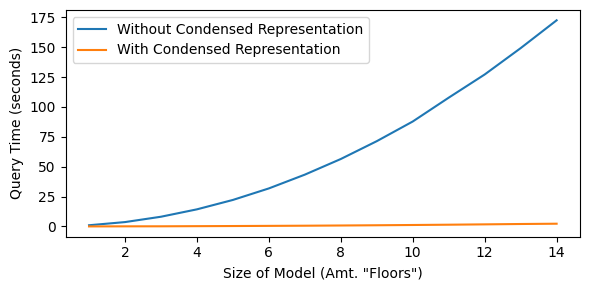

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.ylabel('Query Time (seconds)')
plt.plot(range(1,15),not_condensed_t, label='Without Condensed Representation')
plt.plot(range(1,15),condensed_t, label='With Condensed Representation')
plt.xlabel('Size of Model (Amt. "Floors")')
# plt.xticks(model_length, [f'{1+i} [{x}]' for i,x in enumerate(model_length)])
plt.legend()
plt.tight_layout()
plt.savefig('query-time.png')